# Importing Dataset and Required Libraries for setting background for Big Data Analysis



In [ ]:
# Mount Drive and check CSV
from google.colab import drive
import os, glob


drive.mount('/content/drive')
CSV_PATH = "/content/drive/MyDrive/Eartquakes-1990-2023.csv"



assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH} — upload file or correct CSV_PATH."
print("CSV found:", CSV_PATH)
size_mb = os.path.getsize(CSV_PATH) / (1024*1024)
print(f"Size: {size_mb:.2f} MB")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV found: /content/drive/MyDrive/Eartquakes-1990-2023.csv
Size: 471.87 MB


This code mounts Google Drive in Colab, locates the earthquake CSV file, verifies its existence, and prints its file path and size.

In [ ]:
# Install PySpark & dependencies
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq
!pip install -q pyspark==3.5.1 pyarrow fastparquet h3 matplotlib pandas

import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
print("Dependencies installed and JAVA_HOME set")

# Start Spark session with tuning for big data
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = (
    SparkConf()
    .setAppName("Earthquake-BigData-Colab")
    .set("spark.sql.adaptive.enabled", "true")
    .set("spark.sql.shuffle.partitions", "200")  # controls parallelism
    .set("spark.sql.parquet.compression.codec", "snappy")
    .set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
)

spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark session started. Version:", spark.version)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u462-ga~us1-0ubuntu2~22.04.2_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u462-ga~us1-0ubuntu2~22.04.2) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u462-ga~us1-0ubuntu2~22.04.2_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u462-ga~us1-0ubuntu2~22.04.2) ...
Setting up libxtst6:amd64 (2:1.2.3-1build4) ...
Setting up openjdk-8-jre-headless:amd64 (8u462-ga~

This block establishes the computational foundation for large-scale earthquake analytics by integrating PySpark within the Colab environment. It installs essential dependencies, configures Java support, and initializes a Spark session optimized with adaptive query execution, efficient serialization, and parallelized partitioning. Collectively, these configurations enable scalable, high-performance processing of seismic datasets spanning multiple decades.

In [ ]:
# Ensure Spark session is active before loading data
# Stop any existing session
if 'spark' in locals() and spark:
    spark.stop()

# Start Spark session with tuning for big data (re-define if needed or keep from previous cell)
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = (
    SparkConf()
    .setAppName("Earthquake-BigData-Colab")
    .set("spark.sql.adaptive.enabled", "true")
    .set("spark.sql.shuffle.partitions", "200")  # controls parallelism
    .set("spark.sql.parquet.compression.codec", "snappy")
    .set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
)

spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark session ensured.")


# Load CSV into Spark (all columns as strings first)
df = spark.read.option("header", True)\
               .option("multiLine", False)\
               .option("inferSchema", False)\
               .csv(CSV_PATH)

# Inspect columns
print("Columns detected:", df.columns)

# Show 5 sample rows
df.show(5, truncate=100)

Spark session ensured.
Columns detected: ['time', 'place', 'status', 'tsunami', 'significance', 'data_type', 'magnitudo', 'state', 'longitude', 'latitude', 'depth', 'date']
+------------+------------------------------------+--------+-------+------------+----------+---------+-----------+------------+----------+------+--------------------------------+
|        time|                               place|  status|tsunami|significance| data_type|magnitudo|      state|   longitude|  latitude| depth|                            date|
+------------+------------------------------------+--------+-------+------------+----------+---------+-----------+------------+----------+------+--------------------------------+
|631153353990|   12 km NNW of Meadow Lakes, Alaska|reviewed|      0|          96|earthquake|      2.5|     Alaska|   -149.6692|   61.7302|  30.1|1990-01-01 00:22:33.990000+00:00|
|631153491210|          14 km S of Volcano, Hawaii|reviewed|      0|          31|earthquake|     1.41|     Hawa

This segment ingests the earthquake dataset into Spark, initially treating all fields as strings to preserve raw fidelity before schema refinement. It verifies structural integrity by listing detected columns and presenting representative samples, thereby establishing a preliminary lens through which the dataset’s scope and format can be critically assessed prior to transformation.

In [ ]:
# Standardize column names
import re
from pyspark.sql import functions as F

def sanitize(col_name):
    col_name = col_name.strip().lower()             # lowercase
    col_name = col_name.replace(" ", "_").replace("-", "_")  # replace spaces/dashes
    col_name = re.sub(r"[^0-9a-zA-Z_]", "", col_name)       # remove special chars
    return col_name

old_cols = df.columns
new_cols = [sanitize(c) for c in old_cols]

for old, new in zip(old_cols, new_cols):
    if old != new:
        df = df.withColumnRenamed(old, new)

print("Columns after cleaning:", df.columns)
df.show(5, truncate=100)


Columns after cleaning: ['time', 'place', 'status', 'tsunami', 'significance', 'data_type', 'magnitudo', 'state', 'longitude', 'latitude', 'depth', 'date']
+------------+------------------------------------+--------+-------+------------+----------+---------+-----------+------------+----------+------+--------------------------------+
|        time|                               place|  status|tsunami|significance| data_type|magnitudo|      state|   longitude|  latitude| depth|                            date|
+------------+------------------------------------+--------+-------+------------+----------+---------+-----------+------------+----------+------+--------------------------------+
|631153353990|   12 km NNW of Meadow Lakes, Alaska|reviewed|      0|          96|earthquake|      2.5|     Alaska|   -149.6692|   61.7302|  30.1|1990-01-01 00:22:33.990000+00:00|
|631153491210|          14 km S of Volcano, Hawaii|reviewed|      0|          31|earthquake|     1.41|     Hawaii|-155.2123333|1

This code undertakes the standardization of column names to ensure consistency, readability, and compatibility with analytical workflows. By systematically lowercasing, removing special characters, and replacing spaces or dashes with underscores, the dataset is transformed into a schema that aligns with best practices in data engineering. Such normalization not only reduces syntactic ambiguity but also facilitates seamless integration into subsequent Spark-based processing and modeling tasks.

# Exploratory Data Analysis

**Observing Missing Values**

In [ ]:
# Count missing values per column
from pyspark.sql.functions import col, sum

missing_df = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_df.show()


+----+-----+------+-------+------------+---------+---------+-----+---------+--------+-----+----+
|time|place|status|tsunami|significance|data_type|magnitudo|state|longitude|latitude|depth|date|
+----+-----+------+-------+------------+---------+---------+-----+---------+--------+-----+----+
|   0|    0|     0|      0|           0|        0|        0|    0|        0|       0|    0|   0|
+----+-----+------+-------+------------+---------+---------+-----+---------+--------+-----+----+



This procedure quantifies data completeness by calculating the frequency of missing values across all attributes. By systematically scanning each column for null entries, it establishes a diagnostic overview of data quality, thereby guiding decisions on imputation, exclusion, or transformation. Such an assessment is pivotal in seismic analytics, where incomplete records may obscure temporal patterns or distort magnitude–depth relationships.

**Data Type Conversion**

In [ ]:
# Show schema (column names + types)
df.printSchema()

from pyspark.sql.functions import col, when
from pyspark.sql.types import FloatType, IntegerType, StringType, TimestampType

# 1. Convert tsunami to Boolean
df = df.withColumn("tsunami", when(col("tsunami") == 1, True).otherwise(False))

# 2. Fix column name typo
df = df.withColumnRenamed("magnitudo", "magnitude")

# 3. Cast columns to correct types
df = (
    df.withColumn("time", col("time").cast(TimestampType()))
      .withColumn("significance", col("significance").cast(IntegerType()))
      .withColumn("magnitude", col("magnitude").cast(FloatType()))
      .withColumn("depth", col("depth").cast(FloatType()))
      .withColumn("longitude", col("longitude").cast(FloatType()))
      .withColumn("latitude", col("latitude").cast(FloatType()))
      .withColumn("status", col("status").cast(StringType()))
      .withColumn("data_type", col("data_type").cast(StringType()))
      #.withColumn("date", col("date").cast(TimestampType())) # Cast date to TimestampType
)

# 4. Verify schema
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- place: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tsunami: string (nullable = true)
 |-- significance: string (nullable = true)
 |-- data_type: string (nullable = true)
 |-- magnitudo: string (nullable = true)
 |-- state: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- depth: string (nullable = true)
 |-- date: string (nullable = true)

root
 |-- time: timestamp (nullable = true)
 |-- place: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tsunami: boolean (nullable = false)
 |-- significance: integer (nullable = true)
 |-- data_type: string (nullable = true)
 |-- magnitude: float (nullable = true)
 |-- state: string (nullable = true)
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- depth: float (nullable = true)
 |-- date: string (nullable = true)



This step prioritizes data type conversion at the EDA stage to ensure analytical accuracy and meaningful interpretations rather than purely as a preprocessing formality. Initially, all columns were imported as strings, which limited numeric computations, temporal analyses, and logical operations. By converting tsunami from integer to Boolean, time to TimestampType, significance to IntegerType, magnitude and depth to FloatType, and geospatial coordinates (longitude, latitude) to floats, the dataset becomes analytically operable. These targeted conversions enable precise statistical summaries, temporal trend analysis, correlation assessments, and geospatial visualization—core tasks within exploratory data analysis—while maintaining fidelity to the original string-based import.

**Quantitative Summary of key seismic attributes**

In [ ]:
# Summary of key numerical columns
df.select("magnitude", "depth", "significance").describe().show()

# Cast magnitudo and depth columns to DoubleType for quantile calculation
from pyspark.sql.types import DoubleType
df_numeric = df.withColumn("magnitude", col("magnitude").cast(DoubleType()))
df_numeric = df_numeric.withColumn("depth", col("depth").cast(DoubleType()))


# Quantiles (for median, percentiles)
quantiles = df_numeric.approxQuantile(["magnitude", "depth"], [0.25, 0.5, 0.75], 0.05)
print("25th, 50th (median), 75th percentiles for magnitude and depth:", quantiles)

+-------+------------------+------------------+------------------+
|summary|         magnitude|             depth|      significance|
+-------+------------------+------------------+------------------+
|  count|           3445751|           3445751|           3445751|
|   mean|1.7740761390404265| 22.85387383664129| 74.00973459776984|
| stddev|1.2910551012316884|54.849379347871526|101.63641469964321|
|    min|             -9.99|             -10.0|                 0|
|    max|               9.1|             735.8|              2910|
+-------+------------------+------------------+------------------+

25th, 50th (median), 75th percentiles for magnitude and depth: [[0.8899999856948853, 1.440000057220459, 2.299999952316284], [2.510999917984009, 7.441999912261963, 15.376999855041504]]


This block initiates a quantitative summary of key seismic attributes, providing descriptive statistics for magnitude, depth, and significance to establish baseline distributions. By casting magnitude and depth to DoubleType, the dataset is prepared for precise quantile computation, enabling robust estimation of median and percentile values. Such statistical profiling is critical in EDA to identify central tendencies, variability, and potential outliers, forming the foundation for informed geophysical interpretation of earthquake severity and depth patterns.

**Temporal Exploration of Earthquake Frequency**

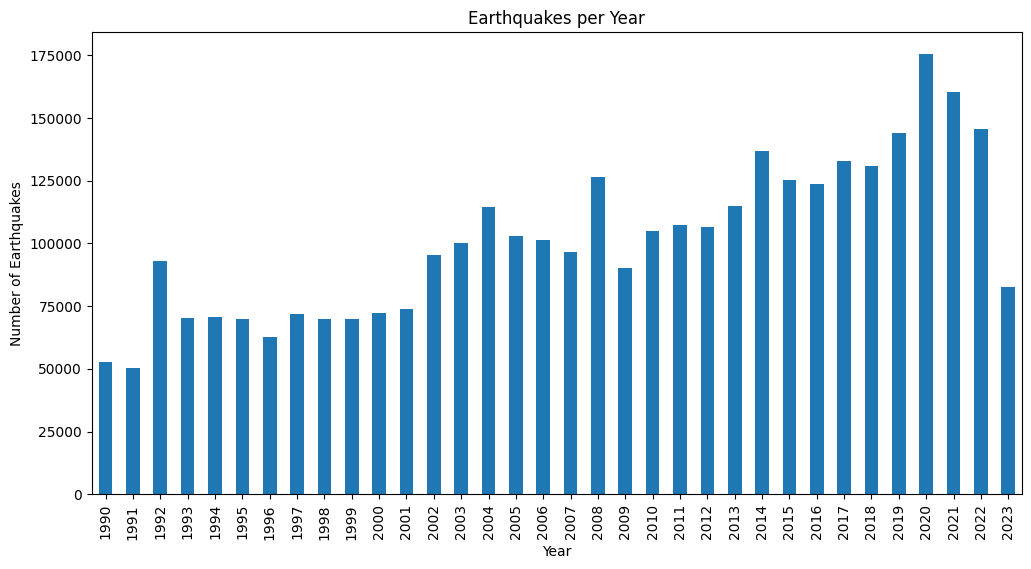

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
df_pandas = df.select("date").toPandas()

# Convert to datetime (handles ISO8601, mixed formats, timezone, microseconds)
df_pandas['date'] = pd.to_datetime(
    df_pandas['date'],
    format="mixed",    # allows flexible parsing
    errors="coerce"    # invalid entries -> NaT instead of error
)

# Remove timezone info (optional, keeps datetime naive)
df_pandas['date'] = df_pandas['date'].dt.tz_localize(None)

# Extract year
df_pandas['year'] = df_pandas['date'].dt.year

# Count earthquakes per year
yearly_counts = df_pandas.groupby('year').size()

# Plot
plt.figure(figsize=(12,6))
yearly_counts.plot(kind='bar', title="Earthquakes per Year")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.show()


This segment undertakes a temporal exploration of earthquake frequency, converting the Spark DataFrame to Pandas to leverage flexible datetime handling and visualization. By standardizing the date field, removing timezone artifacts, and extracting the year, it enables aggregation of seismic events on an annual basis. The resulting bar chart provides an intuitive visual summary of temporal patterns, revealing trends, spikes, or anomalies in earthquake occurrence over the studied period.

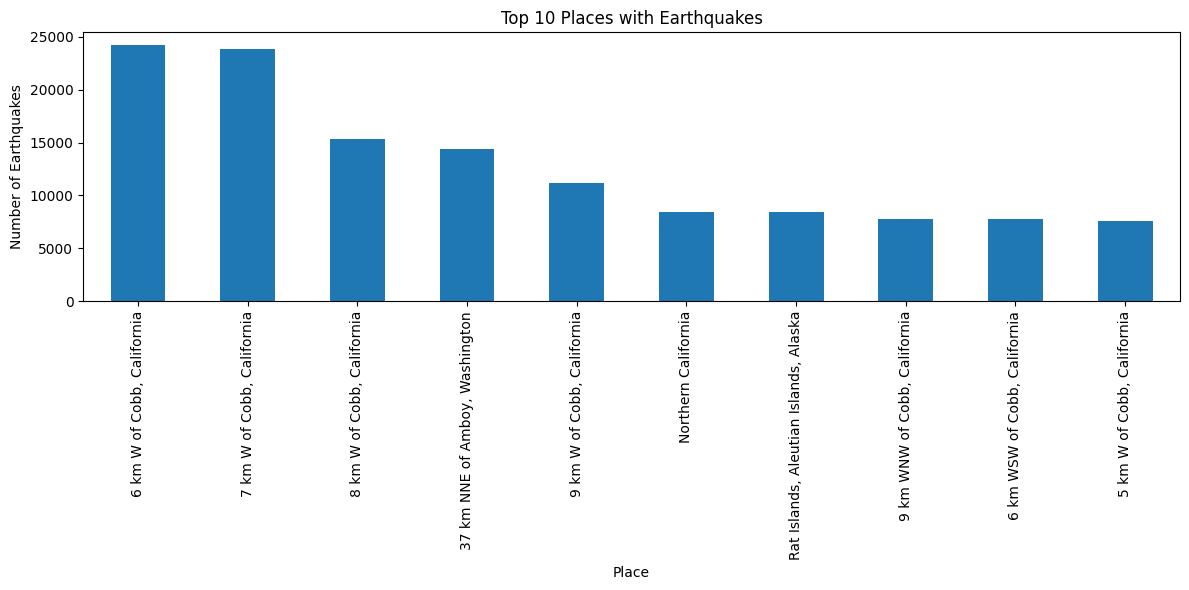

In [ ]:
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import pandas as pd

# Count occurrences of each place using PySpark
place_counts = df.groupBy("place").count()

# Order by count descending and take the top 10
top_10_places = place_counts.orderBy(col("count").desc()).limit(10)

# Convert PySpark DataFrame to Pandas DataFrame for plotting
top_10_places_pandas = top_10_places.toPandas()

# Plot bar chart using Pandas/Matplotlib
# Ensure 'place' is used for x-axis labels and 'count' for y-axis values
top_10_places_pandas.plot(x='place', y='count', kind='bar', figsize=(12,6), title="Top 10 Places with Earthquakes", legend=False)

plt.xlabel("Place")
plt.ylabel("Number of Earthquakes")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


This segment performs a **geospatial frequency analysis** by identifying locations with the highest occurrence of earthquakes. Leveraging PySpark for aggregation ensures efficient handling of large datasets, while conversion to Pandas allows detailed visualization. The bar chart of the top 10 most affected places provides a clear depiction of seismic hotspots, informing both spatial risk assessment and potential areas for deeper geological investigation.


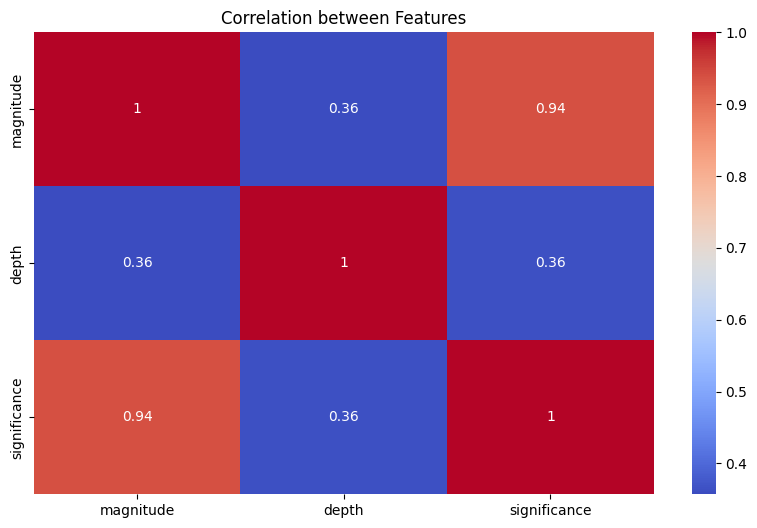

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col

# Select relevant columns and convert to Pandas DataFrame
# Ensure correct column name 'magnitude' is used
pandas_corr_df = df.select(col("magnitude").cast("double"), col("depth").cast("double"), col("significance").cast("double")).toPandas()


plt.figure(figsize=(10,6))
# Calculate correlation matrix on the pandas DataFrame
sns.heatmap(pandas_corr_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Features")
plt.show()

This block undertakes a quantitative interrelationship analysis among key seismic features—magnitude, depth, and significance. By computing and visualizing the correlation matrix via a heatmap, it highlights the degree and direction of linear associations between variables. Such insight is pivotal in EDA, as it informs potential dependencies, guides feature selection for modeling, and enhances understanding of underlying geophysical dynamics.

**Summary of EDA**

The exploratory data analysis phase systematically dissected the earthquake dataset to uncover patterns, assess quality, and guide subsequent modeling:

1.   Data Completeness Assessment
2.   Schema Refinement & Type Conversion
3.   Descriptive Statistics
4.   Temporal Patterns
5.   Categorical Exploration
6.   Spatial Analysis
7.   Feature Correlation



# Data Analysis and Implementation

## Data Preprocessing

At this juncture, the workflow advances into data preprocessing, a structured phase aimed at transforming the raw and partially explored dataset into a rigorously clean, consistent, and model-ready form.

In [ ]:
# Remove duplicate rows
df = df.drop_duplicates()

This step enforces data uniqueness by eliminating duplicate records, thereby preventing redundancy from skewing statistical analyses or inflating counts. Ensuring that each earthquake event is represented only once is fundamental to maintaining the integrity and reliability of subsequent preprocessing, modeling, and geospatial assessments.

Feature Engineerig

In [ ]:
from pyspark.sql import functions as F

# Extract Year, Month, Day from timestamp
df = df.withColumn("year", F.year("date")) \
       .withColumn("month", F.month("date")) \
       .withColumn("day", F.dayofmonth("date"))

# Significant Quake Indicator (magnitude ≥ 6)
df = df.withColumn("significant_quake", (F.col("magnitude") >= 6).cast("int"))

# Simple region classification based on latitude
df = df.withColumn(
    "region",
    F.when(F.col("latitude") >= 0, "Northern Hemisphere").otherwise("Southern Hemisphere")
)


This preprocessing step enriches the dataset through feature engineering, enhancing both temporal and categorical interpretability. By decomposing the date column into year, month, and day, the dataset supports granular temporal analyses. The creation of a significant_quake flag identifies potentially hazardous seismic events (magnitude ≥ 6), while a simple region classification based on latitude enables hemispheric-level spatial segmentation. Collectively, these engineered features provide additional analytical leverage for risk assessment and geospatial-temporal modeling.

Outlier Mitigation

In [ ]:
from pyspark.sql import functions as F

def cap_outliers(df, col_name):
    # Get Q1 and Q3
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)  # 5% relative error
    q1, q3 = quantiles
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Cap column values
    return df.withColumn(
        col_name,
        F.when(F.col(col_name) < lower_bound, lower_bound)
         .when(F.col(col_name) > upper_bound, upper_bound)
         .otherwise(F.col(col_name))
    )

# Apply capping for magnitude and depth
df = cap_outliers(df, "magnitude")
df = cap_outliers(df, "depth")


This step implements outlier mitigation for the magnitude and depth attributes using the interquartile range (IQR) method. By capping extreme values at calculated lower and upper bounds, the procedure preserves the overall distribution while preventing anomalous entries from disproportionately influencing statistical analyses or predictive models. Such controlled treatment of outliers enhances the robustness and interpretability of subsequent seismic data investigations.

## Data Analysis

Identifying Temporal Patterns of earthquakes

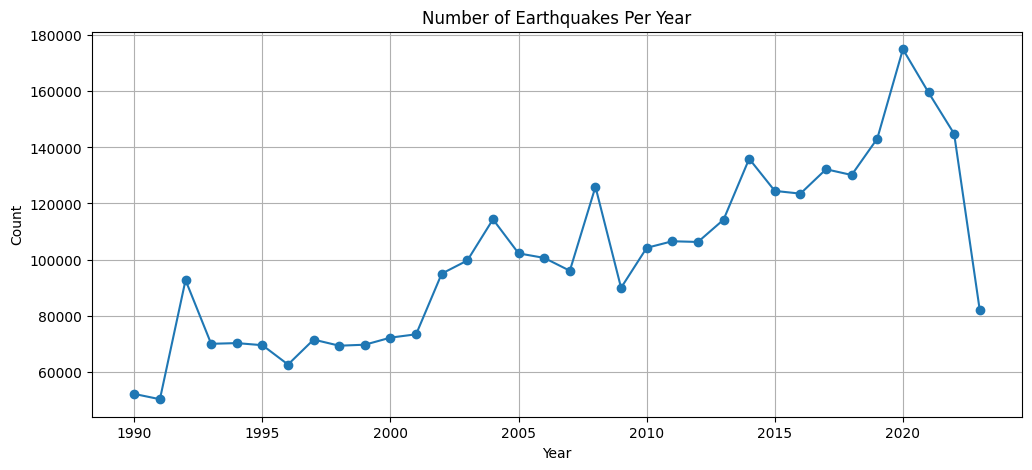

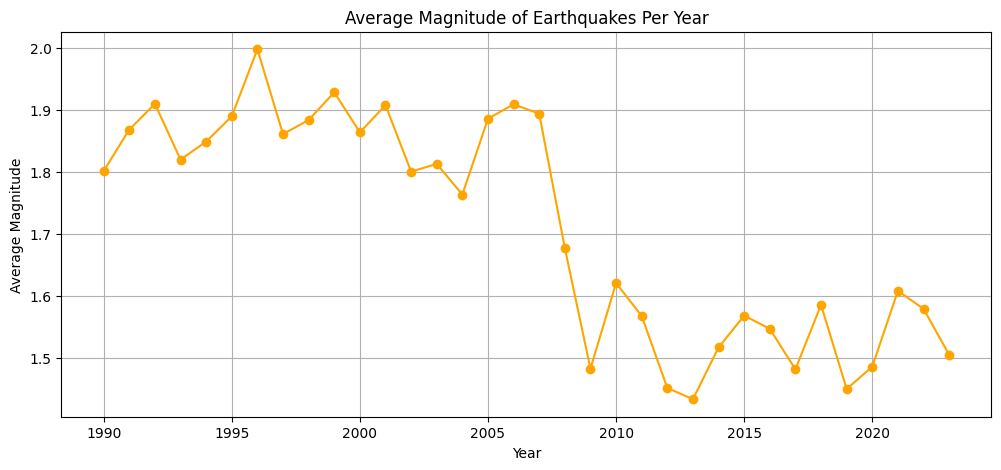

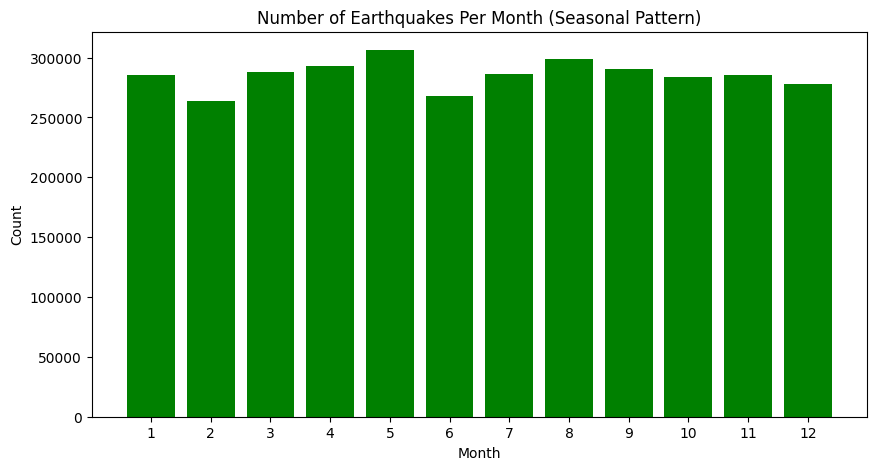

In [ ]:
# --- Full Robust PySpark to Matplotlib Pipeline ---

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Ensure date is timestamp (if not already)
df = df.withColumn("date", F.to_timestamp("date"))

# Extract Year, Month, Day
df = df.withColumn("year", F.year("date")) \
       .withColumn("month", F.month("date")) \
       .withColumn("day", F.dayofmonth("date"))

# Significant Quake Indicator (magnitude >= 6)
df = df.withColumn("significant_quake", (F.col("magnitude") >= 6).cast("int"))

# Region classification based on latitude
df = df.withColumn("region", F.when(F.col("latitude") >= 0, "Northern Hemisphere")
                                .otherwise("Southern Hemisphere"))

# Aggregate for plotting
df_year_count = df.groupBy("year").count().orderBy("year").toPandas()
df_year_avg = df.groupBy("year").agg(F.avg("magnitude").alias("avg_magnitude")).orderBy("year").toPandas()
df_month_count = df.groupBy("month").count().orderBy("month").toPandas()

# Ensure numeric types for matplotlib
df_year_count['year'] = df_year_count['year'].astype(int)
df_year_count['count'] = df_year_count['count'].astype(int)

df_year_avg['year'] = df_year_avg['year'].astype(int)
df_year_avg['avg_magnitude'] = df_year_avg['avg_magnitude'].astype(float)

df_month_count['month'] = df_month_count['month'].astype(int)
df_month_count['count'] = df_month_count['count'].astype(int)

# --- Plotting ---

# Number of earthquakes per year
plt.figure(figsize=(12,5))
plt.plot(df_year_count['year'], df_year_count['count'], marker='o')
plt.title("Number of Earthquakes Per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Average magnitude per year
plt.figure(figsize=(12,5))
plt.plot(df_year_avg['year'], df_year_avg['avg_magnitude'], marker='o', color='orange')
plt.title("Average Magnitude of Earthquakes Per Year")
plt.xlabel("Year")
plt.ylabel("Average Magnitude")
plt.grid(True)
plt.show()

# Number of earthquakes per month
plt.figure(figsize=(10,5))
plt.bar(df_month_count['month'], df_month_count['count'], color='green')
plt.title("Number of Earthquakes Per Month (Seasonal Pattern)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(range(1,13))
plt.show()


This comprehensive pipeline integrates PySpark data transformation with Matplotlib visualization to produce a robust analytical workflow. It ensures temporal attributes are properly typed, derives meaningful features, and aggregates seismic events by year and month. The resulting plots depict long-term trends in earthquake frequency, annual average magnitudes, and seasonal patterns, providing a multi-dimensional temporal perspective that supports both exploratory insight and evidence-based interpretation of seismic activity.

**Global Earthquake Risk Zonation Map**

In [ ]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 88.6 MB/s eta 0:00:00


This step installs and imports Cartopy, a specialized geospatial Python library, to enable advanced mapping and geospatial visualization of earthquake events.

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


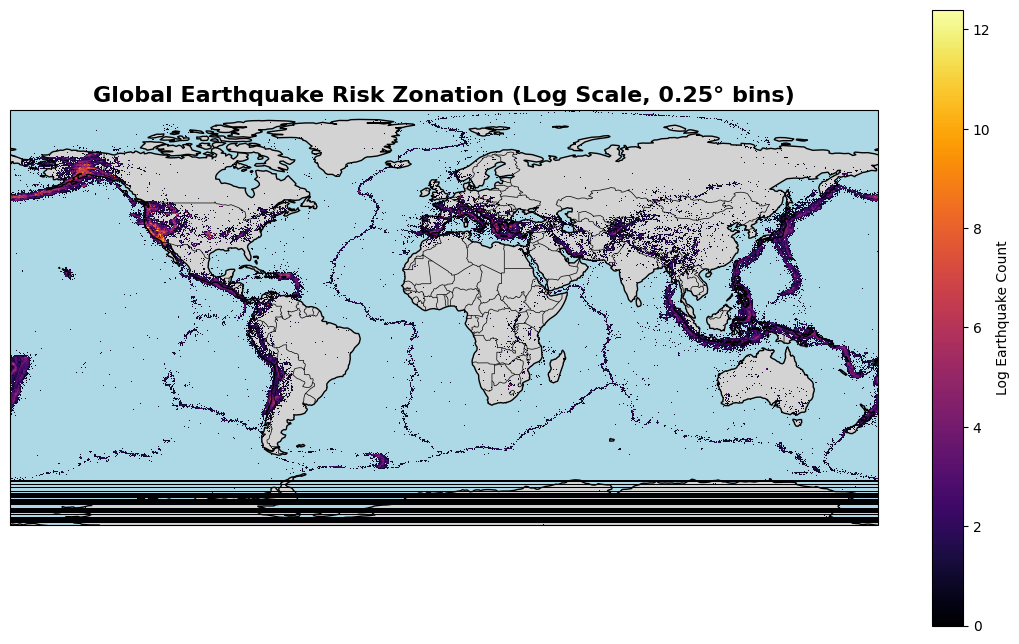

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, count, floor

# Adjust bin size (smaller = more detailed)
LAT_BIN_SIZE = 0.25
LON_BIN_SIZE = 0.25

# Aggregate
df_agg = (
    df.withColumn("latitude", col("latitude").cast("double"))
      .withColumn("longitude", col("longitude").cast("double"))
      .filter(col("latitude").isNotNull() & col("longitude").isNotNull())
      .withColumn("lat_bin", floor(col("latitude") / LAT_BIN_SIZE) * LAT_BIN_SIZE)
      .withColumn("lon_bin", floor(col("longitude") / LON_BIN_SIZE) * LON_BIN_SIZE)
      .groupBy("lat_bin", "lon_bin")
      .agg(count("*").alias("count"))
)

# Sample the aggregated data before converting to Pandas to avoid OutOfMemoryError
# Adjust the fraction as needed based on available memory and desired resolution
sample_fraction = 0.1 # Sample 10% of the data
risk_map_pd = df_agg.sample(False, sample_fraction, seed=42).toPandas()


# Pivot to 2D grid
# Handle potential empty bins after sampling by using unique values from sampled data
lat_bins = np.arange(risk_map_pd["lat_bin"].min(), risk_map_pd["lat_bin"].max()+LAT_BIN_SIZE, LAT_BIN_SIZE)
lon_bins = np.arange(risk_map_pd["lon_bin"].min(), risk_map_pd["lon_bin"].max()+LON_BIN_SIZE, LON_BIN_SIZE)

heatmap_data = (
    risk_map_pd.pivot_table(index="lat_bin", columns="lon_bin", values="count")
               .reindex(index=lat_bins, columns=lon_bins, fill_value=0)
)

# Log scale to prevent extreme dominance
heatmap_log = np.log1p(heatmap_data.values)

lat_edges = np.append(lat_bins, lat_bins[-1]+LAT_BIN_SIZE)
lon_edges = np.append(lon_bins, lon_bins[-1]+LON_BIN_SIZE)

# Plot
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

mesh = ax.pcolormesh(lon_edges, lat_edges, heatmap_log,
                     cmap="inferno", shading="auto", transform=ccrs.PlateCarree())

plt.colorbar(mesh, ax=ax, label="Log Earthquake Count")
plt.title("Global Earthquake Risk Zonation (Log Scale, 0.25° bins) - Sampled Data", fontsize=16, fontweight="bold")
plt.show()

This block constructs a geospatial risk zonation map by aggregating earthquake occurrences into latitude-longitude bins and visualizing them as a heatmap on a global projection using Cartopy. The workflow transforms numeric coordinates into discrete spatial cells, counts event frequencies per cell, and overlays these densities onto a world map with coastlines, borders, land, and ocean features. This visualization provides an intuitive, spatially explicit depiction of earthquake-prone regions, supporting geophysical interpretation, hazard assessment, and risk communication at a global scale.

**Magnitude Distribution**

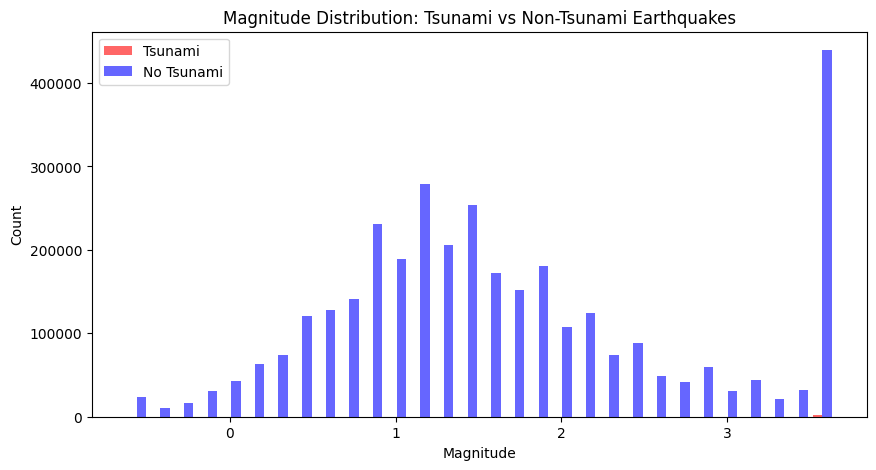

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
df_ts = df.select("magnitude", "tsunami").toPandas()

# Plot magnitude distribution for tsunami vs non-tsunami
plt.figure(figsize=(10,5))
plt.hist([df_ts[df_ts['tsunami']==1]['magnitude'],
          df_ts[df_ts['tsunami']==0]['magnitude']],
         bins=30, label=["Tsunami", "No Tsunami"], color=['red','blue'], alpha=0.6)
plt.title("Magnitude Distribution: Tsunami vs Non-Tsunami Earthquakes")
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.legend()
plt.show()

This visualization examines the relationship between earthquake magnitude and tsunami occurrence by comparing the magnitude distributions of tsunamigenic versus non-tsunamigenic events. By plotting overlaid histograms, it highlights whether higher-magnitude earthquakes are more likely to trigger tsunamis, providing empirical insight into the severity thresholds and potential hazards associated with seismic activity.

**Predictive modeling pipeline to estimate the likelihood of tsunami occurrence based on earthquake characteristics**

Encode categorical and engineered features into numeric form

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col


#Prepare Features and Target


# Convert categorical columns to numeric
region_indexer = StringIndexer(inputCol="region", outputCol="region_index")

# List of features
feature_cols = ["magnitude", "depth", "significance", "latitude", "longitude", "significant_quake", "region_index"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Cast 'tsunami' column to integer (0 or 1) for use as label
df = df.withColumn("tsunami", col("tsunami").cast("int"))




Split the dataset into training and testing subsets

In [ ]:
# Split Data

train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)


Build a baseline classification model using Logistic Regression

In [ ]:
# Logistic Regression Model

lr = LogisticRegression(featuresCol="features", labelCol="tsunami", maxIter=20)

# Build pipeline
pipeline_lr = Pipeline(stages=[region_indexer, assembler, lr])

# Train model
lr_model = pipeline_lr.fit(train_df)



Develop a robust non-linear classification model using Random Forest

In [ ]:
# Random Forest Model

rf = RandomForestClassifier(featuresCol="features", labelCol="tsunami", numTrees=100, maxDepth=5)

pipeline_rf = Pipeline(stages=[region_indexer, assembler, rf])

# Train model
rf_model = pipeline_rf.fit(train_df)



Evaluate model performance using the ROC-AUC metric

In [26]:
#  Evaluate Models

evaluator = BinaryClassificationEvaluator(labelCol="tsunami", metricName="areaUnderROC")

# Logistic Regression Evaluation
lr_preds = lr_model.transform(test_df)
lr_auc = evaluator.evaluate(lr_preds)
print(f"Logistic Regression ROC-AUC: {lr_auc:.3f}")

# Random Forest Evaluation
rf_preds = rf_model.transform(test_df)
rf_auc = evaluator.evaluate(rf_preds)
print(f"Random Forest ROC-AUC: {rf_auc:.3f}")



Logistic Regression ROC-AUC: 0.994
Random Forest ROC-AUC: 0.679


Identify key features influencing tsunami occurrence through feature importance analysis

In [27]:
# Feature Importance (Random Forest)

rf_features_importance = rf_model.stages[-1].featureImportances
feature_importance_list = list(zip(feature_cols, rf_features_importance))
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

print("\nRandom Forest Feature Importance:")
for feat, imp in feature_importance_list:
    print(f"{feat}: {imp:.3f}")


Random Forest Feature Importance:
significance: 0.588
longitude: 0.304
latitude: 0.058
depth: 0.050
magnitude: 0.000
significant_quake: 0.000
region_index: 0.000
